# Understanding hl2ss 3D CV Code

There is just way too much format with the Microsoft Hololens.

This notebook will be utilized to test all of the aspects of the 3dcv hololens code.

Make sure we can perform the things we want with the calibration data and everything in mind.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from mpl_toolkits import mplot3d

%matplotlib inline

In [10]:
#hl2ss import code

import sys
sys.path.append("/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/hl2ss/viewer")

In [11]:
import hl2ss
import hl2ss_3dcv

In [12]:
PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/an_place/raw-04-09-08-07/'
def get_calibration():
    calib_pv = hl2ss_3dcv._load_calibration_pv(PATH+'../calibrations/personal_video')
    calib_lt = hl2ss_3dcv._load_calibration_rm_depth_longthrow(PATH+'../calibrations/rm_depth_longthrow')
    calib_rf = hl2ss_3dcv._load_calibration_rm_vlc(PATH+'../calibrations/rm_vlc_rightfront')
    calib_lf = hl2ss_3dcv._load_calibration_rm_vlc(PATH+'../calibrations/rm_vlc_leftfront')
    
    uv2xy = hl2ss_3dcv.compute_uv2xy(calib_lt.intrinsics, hl2ss.Parameters_RM_DEPTH_LONGTHROW.WIDTH, hl2ss.Parameters_RM_DEPTH_LONGTHROW.HEIGHT)
    xy1, scale = hl2ss_3dcv.rm_depth_compute_rays(uv2xy, calib_lt.scale)
    
    #return all calibrations + xy1 + scale
    return calib_pv, calib_lt, calib_lf, calib_rf, xy1, scale

In [18]:
#get all calibrations
calib_pv, calib_lt, calib_lf, calib_rf, xy, scale = get_calibration()

## Depth Rays

The "xy" variable or the rays representation is a projective dual of the $(u,v)$ points. So you project into $z=1$ plane and $(u,v)$ is scaled exactly like how the longthrow sensor rays work in real life.

Rays shape: (288, 320, 3)


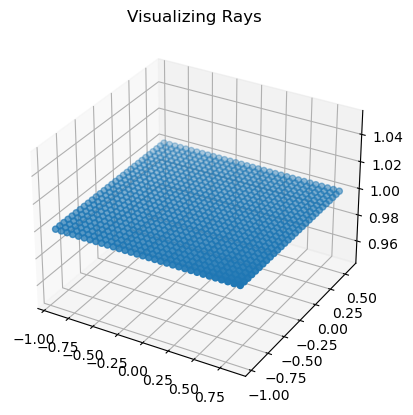

In [24]:
print(f'Rays shape: {xy.shape}')
fig = plt.figure()
ax = plt.axes(projection='3d')

#visualize every other 10 to get the dots
ax.scatter3D(xy[::10,::10,0].flatten(),xy[::10,::10,1].flatten(),xy[::10,::10,2].flatten())
plt.title('Visualizing Rays')
plt.show()

## Getting Depth Points

Now that we have the rays represented as $(x,y,1)$, if we scaled it with the depth image, 

then we will get the rays scaled to get the exact depth we would want.

this is now our point clouds in the Longthrow Frame IN METERS

In [37]:
# xx and yy are 200x200 tables containing the x and y coordinates as values
# mgrid is a mesh creation helper
xx, yy = np.mgrid[:288, :320]
# circles contains the squared distance to the (100, 100) point
# we are just using the circle equation learnt at school
circle = (xx - 100) ** 2 + (yy - 100) ** 2
# donuts contains 1's and 0's organized in a donut shape
# you apply 2 thresholds on circle to define the shape
donut = (np.logical_and(circle < (6400 + 60), circle > (6400 - 60)))*5

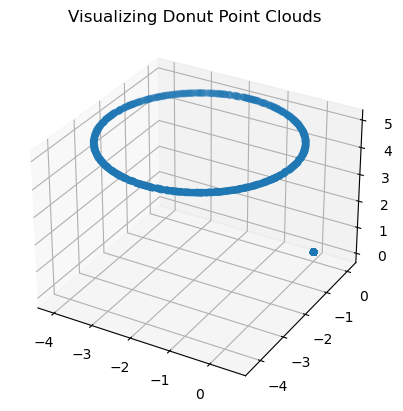

In [38]:
point_clouds = xy*donut[:,:,np.newaxis]

fig = plt.figure()
ax = plt.axes(projection='3d')

#visualize every other 10 to get the dots
ax.scatter3D(point_clouds[:,:,0].flatten(),point_clouds[:,:,1].flatten(),point_clouds[:,:,2].flatten())
plt.title('Visualizing Donut Point Clouds')
plt.show()

## Visualizing Camera Pose